<div> Group: Lumin, Ash Malmlov, Katrina Wheeler </div>
<div> Presentation Date: 03/06/2023 </div>
<div> COMP 4447 </div>
<div> Final Project </div>

<h2>Introduction</h2>

Compiling peer-reviewed literature is a key part of science and research. Yet the task of literature compilation is quite laborious and dependent upon human tenacity. A typical workflow includes identifying a series of scholarly search engines, listing out multiple query parameters, searching each search engine with each query parameter and getting the search engine results page (SERP), manually looking at each literature element returned to determine if it is generally within the realm of the subject matter, if it is--documenting that literature element in a spreadsheet, and moving onto the next element until the end of the page is reached, and then moving onto the next page. Within this methodology, a person needs to develop a system to remove duplicates, track papers that are not useful, and manually filter through hundreds of pages and thousands of articles returned by the search engine. What often happens, given the default order of papers in the SERP is by relevancy, is researchers continue through the pages until any given page returns papers that do not appear relevant, then the researcher calls it "good enough", and stops. The algorithm used by these search engines to determine relevancy is unclear, so it always leaves the question: was it good enough?

This is a very time intensive and laborious process. It is difficult to reserve an uninterrupted block of time in order to completely, manually scrape the SERP. As such, researchers tend to get as far as they can in any given span of time, and then when they run out of time, will return to the task later by using the same search parameters and essentially trying to pick up where they left off. The problem with this is that every query results in a unique instance, so a researcher is never truly picking up where they left off. 

The result of all of this work is the first pass through for literature compilation. After all literature from all the queries, from all the search engines have manually, laboriously been compiled, researchers then manually filter out irrelevent papers at a higher resultion--gradually widdling down their list of literature that meets the criteria of the subject matter they are investigating. 

Given the time intensive and laborious nature of this process, the quality of the results is often dependent on the researchers ability to persevere in the face of extreme monotony and redundancy. As such it is a process dependent on human tenacity. 

Here, we take a first pass at drafting a program to automate the process of literature compilation. We address this problem by leveraging automated web scraping techniques to compile SERPS from multiple search engines into a single dataframe, analyze results, filter out duplicate entries, and use natural language processing techniques to assign relevancy scores to each unique entry. This is a user dependent process where the user must identify the search engines to query, provide generalized search parameters to conduct those queries, and then an extensive key word list to assign relevancy scores. A diagram of the work flow is below.


Question: what other work has been done in this area?

<h2>Resources</h2>
<ol>
<li>Sayers E. The E-utilities In-Depth: Parameters, Syntax and More. 2009 May 29 [Updated 2022 Nov 30]. In: Entrez Programming Utilities Help [Internet]. Bethesda (MD): National Center for Biotechnology Information (US); 2010-. Available from: https://www.ncbi.nlm.nih.gov/books/NBK25499/ </li>
<li>https://www.medrxiv.org/content/10.1101/2021.07.14.21260492v1.full.pdf</li>

</ol>

<img src="litSearchWorkFlowLandscape-04.png"/>

<h2>Subject (user defined) Used for Development and Testing:</h2>

<div>This program was simulatanesouly tested while being designed on a biological subject matter that represents what a user would input.</div>

<div>The subject matter tested was bats and serology and the users compile literature to write a review with the proposed title: "Determing trends in the duration of maternal antibodies and seasonal shedding patterns associated with parturition in different bat species for different viruses."</div>
</br>
<div>To meet the user's goals, the user (Ash) supplied the following files:</div>
<ol>
<li>search_engine_parameters.txt: A list of all queries to be made of the different search engines.</br>Delimiter = '\n'</li></br>
<li>keywords_bats.txt: A list of all general use terms for bats, order name, bat suborders, bat families and bat generas to identify all papers that involve bats and exclude those that use the term "BAT" in different context (such as basophil activation test).</br>Delimiter = ','</li>
</br>
<li>keywords_general.txt: A list of all ancilliary keywords in conjunction with keywords meaning bats to apply a secondary filter and relevancy score to each article.</br>Delimiter = ',' </br>Using this file, an in place dictionary was built where the user identified weights associated with each keyword.</li>
</ol>

<h2>The Program:</h2>

<h3>Libraries:</h3>

In [3]:
#data management
import pandas as pd
import numpy as np

#scraping pubmed
import re
import urllib
from time import sleep
from datetime import date

#scraping google scholar & research gate
from selenium import webdriver
from selenium.webdriver.common.by import By
import time

#scraping google
from bs4 import BeautifulSoup
import requests
from selenium.webdriver.common.keys import Keys

#scraping research gate
from more_itertools import consecutive_groups
from pretty_html_table import build_table
from IPython.display import display, HTML
from selenium import webdriver
from selenium.webdriver.common.by import By
import csv
import time 
import pandas as pd
import os
import glob


#natural language processing
import string
from nltk.corpus import stopwords
from wordcloud import STOPWORDS
import contractions
from nltk.stem import WordNetLemmatizer

#data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

ModuleNotFoundError: No module named 'wordcloud'

<h3>Dataframe that will be populated with each article returned from web scraping:</h3>

In [2]:
cols = [ 'Title', 'Authors', 'Publication Year', 'Abstract', 'Journal/Source', 'Citation', 'Publication Date', 'DOI', 'Time Stamp', 'Query Parameters', 'Search Engine']

df = pd.DataFrame(columns=cols)
df

,Title,Authors,Publication Year,Abstract,Journal/Source,Citation,Publication Date,DOI,Time Stamp,Query Parameters,Search Engine


<h3>Web Scraping:</h3>

<h4>Search Engine: Pubmed</h4>

In [8]:
def scrapePubMed(query):
    """Takes in a query parameter to pass into pubmed e-utilities and scrape all search engine results pages yielded from the query.

    Args:
        query (string): Query to search pubmed. If string is comprised of multiple words, spaces must be replaced with '+'.

    Returns:
        list: returns a list of all scraped serps where each element in the list is variable components describing an individual peer-reviewed publication, including but not limited to: article name, authors, citation, abstract, and doi.
    """

    # common settings between esearch and efetch
    base_url = 'http://eutils.ncbi.nlm.nih.gov/entrez/eutils/'
    db = 'db=pubmed'

    # esearch settings
    search_eutil = 'esearch.fcgi?'
    search_term = '&term=' + query
    search_usehistory = '&usehistory=y'
    search_rettype = '&rettype=json'

    # call the esearch command for the query and read the web result
    search_url = base_url+search_eutil+db+search_term+search_usehistory+search_rettype
    f = urllib.request.urlopen (search_url)
    search_data = f.read().decode('utf-8')

    # extract the total abstract count
    total_abstract_count = int(re.findall("<Count>(\d+?)</Count>",search_data)[0])

    # efetch settings
    fetch_eutil = 'efetch.fcgi?'
    retmax = 20
    retstart = 0
    fetch_retmode = "&retmode=text"
    fetch_rettype = "&rettype=abstract"

    # obtain webenv and querykey settings from the esearch results
    fetch_webenv = "&WebEnv=" + re.findall ("<WebEnv>(\S+)<\/WebEnv>", search_data)[0]
    fetch_querykey = "&query_key=" + re.findall("<QueryKey>(\d+?)</QueryKey>",search_data)[0]

    # call efetch commands using a loop until all publications are obtained
    run = True
    all_publications = list()
    loop_counter = 1

    while run:
        print("this is efetch run number " + str(loop_counter))
        loop_counter += 1
        fetch_retstart = "&retstart=" + str(retstart)
        fetch_retmax = "&retmax=" + str(retmax)
        # create the efetch url
        fetch_url = base_url+fetch_eutil+db+fetch_querykey+fetch_webenv+fetch_retstart+fetch_retmax+fetch_retmode+fetch_rettype
        print(f'Fetch URL: {fetch_url}')
        # open the efetch url
        f = urllib.request.urlopen (fetch_url)
        fetch_data = f.read().decode('utf-8')
        # split the data into individual publications
        publications = fetch_data.split("\n\n\n")
        # append to the list all_publications
        all_publications = all_publications+publications
        print(f"{str(len(all_publications))} publications have been downloaded.\n")
        # wait 2 seconds so we don't get blocked
        sleep(2)
        # update retstart to download the next chunk of publications
        retstart = retstart + retmax
        if retstart > total_abstract_count:
            run = False
    return all_publications

In [9]:
def createPubMedDataframe(publicationsList, df, query, date):
    """Takes the list of publications generated by scrapePubMed() function and creates a dataframe so that each publication is a row. 

    Args:
        publicationsList (list): list of publications obtained from scraping Pubmed search engine results page
        df (pandas dataframe): dataframe to populate
        query (string): query used to generate results returned by Pubmed
        date (string): date of query

    Returns:
        pandas dataframe: dataframe with each literature as its own row. 
    """
    searchEngine = "pubmed"

    for i, pub in enumerate(publicationsList):
        print(f"Currently on {i} out of {len(publicationsList)}")
        if "retracted" in pub.lower():
            continue
        dfRow = []
        split_entry = pub.split("\n\n")

        if "correction" in split_entry[1].lower():
            continue
        else:
            title = split_entry[1]

            authors = split_entry[2]
            authors = re.sub(r"\([1-9]\)", '', authors)

            if len(split_entry) < 5:
                abstract = np.nan
            elif "article" in split_entry[2].lower():
                for e in split_entry:
                    if len(e.split()) < 30:
                        abstract = np.nan
                    else:
                        abstract = split_entry[5]
                language = split_entry[2].split(";")[0].strip('[')
                title = language + ":" + split_entry[1]
                authors = split_entry[3]
            elif "collaborators" in split_entry[3].lower():
                abstract = split_entry[4]
            elif "comment in" in split_entry[4].lower(): 
                if "update of" in split_entry[5].lower():
                    abstract = split_entry[6]
                if "update of" not in split_entry[5].lower():
                    abstract = split_entry[5]
            elif "erratum" in split_entry[4].lower():
                if "update of" in split_entry[5].lower():
                    abstract = split_entry[6]
                elif "comment" in split_entry[5].lower():
                    abstract = split_entry[6]
                elif "update of" not in split_entry[5].lower():
                    abstract = split_entry[5]
                elif "comment" not in split_entry[5].lower():
                    abstract = split_entry[5]
            elif "author information" in split_entry[3].lower():
                if "update" in split_entry[4].lower():
                    abstract = split_entry[5]
                if "update" not in split_entry[4].lower():
                    abstract = split_entry[4]
            else:
                abstract = split_entry[3]

            citation = split_entry[0]
            citationList = citation.split(". ")
            journal = citationList[1]
            year = citationList[2].split(" ")[0]

            if ";" in citationList[2]:
                volIssuePage = citationList[2].split(";")[1]
                date = citationList[2].split(";")[0]
            else: 
                volIssuePage = citationList[2]
                date = np.nan

            doiList = [i for i in citationList if "doi" in i]
            for e in doiList:
                doi = e.strip("doi: ")

            dfRow.append(title)
            dfRow.append(authors)
            dfRow.append(year)
            dfRow.append(abstract)
            dfRow.append(journal)
            dfRow.append(volIssuePage)
            dfRow.append(date)
            dfRow.append(doi)
            dfRow.append(date)
            dfRow.append(query)
            dfRow.append(searchEngine)
            df.loc[len(df)] = dfRow
    return df

In [10]:
#open document that lists search parameters and creates a list of those parameters
with open('search_engine_parameters_modified.txt', 'r') as f:
    queryList = [line.strip() for line in f]
queryList

['bat+viral+immune+serology',
 'maternal+antibodies+chiroptera',
 'maternal+antibodies+bats',
 'serology+chiroptera',
 'serology+bat',
 'bats+age+serology',
 'bats+antibodies',
 'chiroptera+antibodies']

In [11]:
#for each query in the list, scrape the SERP using scrapePubMed() function and populate a dataframe using createPubMedDataframe() function 
for query in queryList:
    print('*'*80)
    print(query)
    publications = scrapePubMed(query)
    df = df.append(createPubMedDataframe(publications, df, query, '03-05-2023'))

********************************************************************************
bat+viral+immune+serology
this is efetch run number 1
Fetch URL: http://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&query_key=1&WebEnv=MCID_6404fd95201a7c7bf20144fc&retstart=0&retmax=20&retmode=text&rettype=abstract
20 publications have been downloaded.

this is efetch run number 2
Fetch URL: http://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&query_key=1&WebEnv=MCID_6404fd95201a7c7bf20144fc&retstart=20&retmax=20&retmode=text&rettype=abstract
40 publications have been downloaded.

this is efetch run number 3
Fetch URL: http://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&query_key=1&WebEnv=MCID_6404fd95201a7c7bf20144fc&retstart=40&retmax=20&retmode=text&rettype=abstract
51 publications have been downloaded.

Currently on 0 out of 51
Currently on 1 out of 51
Currently on 2 out of 51
Currently on 3 out of 51
Currently on 4 out of 51
Currently on 5 out of 51
Curren

<ipython-input-11-f00bc5e1149a>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(createPubMedDataframe(publications, df, query, '03-05-2023'))


this is efetch run number 1
Fetch URL: http://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&query_key=1&WebEnv=MCID_6404fd9eb2c706488d191212&retstart=0&retmax=20&retmode=text&rettype=abstract
14 publications have been downloaded.

Currently on 0 out of 14
Currently on 1 out of 14
Currently on 2 out of 14
Currently on 3 out of 14
Currently on 4 out of 14
Currently on 5 out of 14
Currently on 6 out of 14
Currently on 7 out of 14
Currently on 8 out of 14
Currently on 9 out of 14
Currently on 10 out of 14
Currently on 11 out of 14
Currently on 12 out of 14
Currently on 13 out of 14
********************************************************************************
maternal+antibodies+bats


<ipython-input-11-f00bc5e1149a>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(createPubMedDataframe(publications, df, query, '03-05-2023'))


this is efetch run number 1
Fetch URL: http://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&query_key=1&WebEnv=MCID_6404fda1bd5d9300984dd391&retstart=0&retmax=20&retmode=text&rettype=abstract
19 publications have been downloaded.

Currently on 0 out of 19
Currently on 1 out of 19
Currently on 2 out of 19
Currently on 3 out of 19
Currently on 4 out of 19
Currently on 5 out of 19
Currently on 6 out of 19
Currently on 7 out of 19
Currently on 8 out of 19
Currently on 9 out of 19
Currently on 10 out of 19
Currently on 11 out of 19
Currently on 12 out of 19
Currently on 13 out of 19
Currently on 14 out of 19
Currently on 15 out of 19
Currently on 16 out of 19
Currently on 17 out of 19
Currently on 18 out of 19
********************************************************************************
serology+chiroptera


<ipython-input-11-f00bc5e1149a>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(createPubMedDataframe(publications, df, query, '03-05-2023'))


this is efetch run number 1
Fetch URL: http://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&query_key=1&WebEnv=MCID_6404fda5434e5629a41dfbf2&retstart=0&retmax=20&retmode=text&rettype=abstract
20 publications have been downloaded.

this is efetch run number 2
Fetch URL: http://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&query_key=1&WebEnv=MCID_6404fda5434e5629a41dfbf2&retstart=20&retmax=20&retmode=text&rettype=abstract
40 publications have been downloaded.

this is efetch run number 3
Fetch URL: http://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&query_key=1&WebEnv=MCID_6404fda5434e5629a41dfbf2&retstart=40&retmax=20&retmode=text&rettype=abstract
60 publications have been downloaded.

this is efetch run number 4
Fetch URL: http://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&query_key=1&WebEnv=MCID_6404fda5434e5629a41dfbf2&retstart=60&retmax=20&retmode=text&rettype=abstract
80 publications have been downloaded.

this is efetch ru

<ipython-input-11-f00bc5e1149a>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(createPubMedDataframe(publications, df, query, '03-05-2023'))


this is efetch run number 1
Fetch URL: http://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&query_key=1&WebEnv=MCID_6404fdc9460eec003c07da40&retstart=0&retmax=20&retmode=text&rettype=abstract
20 publications have been downloaded.

this is efetch run number 2
Fetch URL: http://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&query_key=1&WebEnv=MCID_6404fdc9460eec003c07da40&retstart=20&retmax=20&retmode=text&rettype=abstract
40 publications have been downloaded.

this is efetch run number 3
Fetch URL: http://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&query_key=1&WebEnv=MCID_6404fdc9460eec003c07da40&retstart=40&retmax=20&retmode=text&rettype=abstract
60 publications have been downloaded.

this is efetch run number 4
Fetch URL: http://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&query_key=1&WebEnv=MCID_6404fdc9460eec003c07da40&retstart=60&retmax=20&retmode=text&rettype=abstract
80 publications have been downloaded.

this is efetch ru

<ipython-input-11-f00bc5e1149a>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(createPubMedDataframe(publications, df, query, '03-05-2023'))


this is efetch run number 1
Fetch URL: http://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&query_key=1&WebEnv=MCID_6404fdee434e5629a41dfc07&retstart=0&retmax=20&retmode=text&rettype=abstract
14 publications have been downloaded.

Currently on 0 out of 14
Currently on 1 out of 14
Currently on 2 out of 14
Currently on 3 out of 14
Currently on 4 out of 14
Currently on 5 out of 14
Currently on 6 out of 14
Currently on 7 out of 14
Currently on 8 out of 14
Currently on 9 out of 14
Currently on 10 out of 14
Currently on 11 out of 14
Currently on 12 out of 14
Currently on 13 out of 14
********************************************************************************
bats+antibodies


<ipython-input-11-f00bc5e1149a>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(createPubMedDataframe(publications, df, query, '03-05-2023'))


this is efetch run number 1
Fetch URL: http://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&query_key=1&WebEnv=MCID_6404fdf200859b1082714e05&retstart=0&retmax=20&retmode=text&rettype=abstract
20 publications have been downloaded.

this is efetch run number 2
Fetch URL: http://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&query_key=1&WebEnv=MCID_6404fdf200859b1082714e05&retstart=20&retmax=20&retmode=text&rettype=abstract
40 publications have been downloaded.

this is efetch run number 3
Fetch URL: http://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&query_key=1&WebEnv=MCID_6404fdf200859b1082714e05&retstart=40&retmax=20&retmode=text&rettype=abstract
60 publications have been downloaded.

this is efetch run number 4
Fetch URL: http://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&query_key=1&WebEnv=MCID_6404fdf200859b1082714e05&retstart=60&retmax=20&retmode=text&rettype=abstract
80 publications have been downloaded.

this is efetch ru

<ipython-input-11-f00bc5e1149a>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(createPubMedDataframe(publications, df, query, '03-05-2023'))


this is efetch run number 1
Fetch URL: http://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&query_key=1&WebEnv=MCID_6404fe95138e920b514e1420&retstart=0&retmax=20&retmode=text&rettype=abstract
20 publications have been downloaded.

this is efetch run number 2
Fetch URL: http://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&query_key=1&WebEnv=MCID_6404fe95138e920b514e1420&retstart=20&retmax=20&retmode=text&rettype=abstract
40 publications have been downloaded.

this is efetch run number 3
Fetch URL: http://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&query_key=1&WebEnv=MCID_6404fe95138e920b514e1420&retstart=40&retmax=20&retmode=text&rettype=abstract
60 publications have been downloaded.

this is efetch run number 4
Fetch URL: http://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&query_key=1&WebEnv=MCID_6404fe95138e920b514e1420&retstart=60&retmax=20&retmode=text&rettype=abstract
80 publications have been downloaded.

this is efetch ru

<ipython-input-11-f00bc5e1149a>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(createPubMedDataframe(publications, df, query, '03-05-2023'))


In [13]:
#create a csv file of the unaltered dataframe generated above to work from as needed
df.to_csv('pubmedDF_03-05-2023.csv', index=False)

<h4>Search Engine: Google Scholar</h4>

In [22]:
search_terms = open("search_engine_parameters_modified.txt", "r")

titles = []
authors = []
description = []
links = []
parameters = []
date = []
today = '03-05-2023'

def scrape_google_scholar(parameter):
    
    #Using webdriver to go to Google Scholar
    driver = webdriver.Chrome()
    driver.get("https://scholar.google.com/schhp?hl=en&as_sdt=0,48")

    #Finding search bar, inputting parameter and hitting enter
    search = driver.find_element(By.NAME, 'q')
    search.send_keys(parameter)
    search.send_keys(Keys.RETURN)
  
    counter = 1
    while counter <= 2:
        #getting current url for BS webscrapping, setting up lists for DF
        url = driver.current_url
        #Scraping title, link, authors, and description, adding to lists then adding lists to DF
        response=requests.get(url)
        soup = BeautifulSoup(response.content, 'lxml')  
        for item in soup.select('[data-lid]'):
            t = item.select('h3')[0].get_text() #title
            print(f'found item {t} on page {counter} for parameter {parameter}')
            titles.append(t)
            a = item.select('.gs_a')[0].get_text() #author
            authors.append(a)
            d = item.select('.gs_rs')[0].get_text() #description
            description.append(d)
            l = item.select('a')[0]['href']
            links.append(l)
            parameters.append(parameter)
            date.append(today)
        sleep_time = (30-5)*np.random.random()+5
        time.sleep(sleep_time) #from 5 to 30 seconds
        counter += 1
        next_page = driver.find_element(By.XPATH, '//*[@id="gs_n"]/center/table/tbody/tr/td[12]/a/b')
        next_page.click()
    
for value in search_terms:
    scrape_google_scholar(value.replace('\n', ''))
    
search_engine = ["Google Scholar" for value in titles]
    
gs_df = pd.DataFrame(list(zip(titles, authors, description, links, parameters, search_engine, date)), columns = ["Title", "Authors", "Abstract", "Links", "Query Parameters", "Search Engine", "Time Stamp"])

found item [HTML][HTML] Bat-borne virus diversity, spillover and emergence on page 1 for parameter bat+viral+immune+serology
found item [HTML][HTML] Support for viral persistence in bats from age-specific serology and models of maternal immunity on page 1 for parameter bat+viral+immune+serology
found item [HTML][HTML] Novel insights into immune systems of bats on page 1 for parameter bat+viral+immune+serology
found item Immune system modulation and viral persistence in bats: understanding viral spillover on page 1 for parameter bat+viral+immune+serology
found item Robust dengue virus infection in bat cells and limited innate immune responses coupled with positive serology from bats in IndoMalaya and Australasia on page 1 for parameter bat+viral+immune+serology
found item [HTML][HTML] Duration of maternal antibodies against canine distemper virus and Hendra virus in pteropid bats on page 1 for parameter bat+viral+immune+serology
found item Disentangling serology to elucidate henipa‐and 

In [23]:
#create a csv file of the unaltered dataframe generated above to work from as needed
df.to_csv('googleScholarDR_03-05-2023.csv', index=False)

<h4>Search Engine: Research Gate</h4>

Checking the sites operating preferences

https://www.researchgate.net/robots.txt
User-agent: *
Allow: /
Disallow: /cdn-cgi/
Disallow: /connector/
Disallow: /plugins.
Disallow: /firststeps.
Disallow: /publicliterature.PublicLiterature.search.html
Disallow: /lite.publication.PublicationRequestFulltextPromo.requestFulltext.html
Disallow: /amp/authorize
Allow: /signup.SignUp.html
Disallow: /signup.

In [5]:
#Retrieving the saved list URLS

username='lumin.lumin@du.edu'
password = "1q2w!Q@W"
#def researchgateLogin(u,p):  # user / password  run function

driver = webdriver.Chrome('chromedriver')
driver.get("https://www.researchgate.net/login?_sg=NwdtVE70_zdviOxDKwzwMMj7XJBOecrxh3_txMgRe08qjVOr9JhOiTknCb2yzOwWlYRSbgRqKXoikvZlmZXacQ")
time.sleep(3)
uname = driver.find_element(By.NAME, "login") 
uname.send_keys(username)
time.sleep(3)
pword = driver.find_element("id", "input-password") 
pword.send_keys(password)
driver.find_element(By.CSS_SELECTOR, '[type="submit"]').click()

#pullSavedList  
    #profile
driver.find_element(By.XPATH, "/html/body/div[1]/div[1]/header/nav/ul[2]/li[5]/span[2]/div/div/a").click()
    #saved list from profile drop down
driver.find_element(By.XPATH, "/html/body/div[1]/div[1]/header/nav/ul[2]/li[5]/span[2]/div[2]/div/ul/li[2]/a/span/div").click()
time.sleep(2)
    #specify saved list  (not saved AND archived)
driver.find_element(By.XPATH,"/html/body/div[1]/div[3]/div[1]/div/div/div[2]/div[1]/div/div/div/div/div[2]/div/div[1]/div/div[2]/div/nav/div/div/button[2]/div/div").click()
time.sleep(2)   


#pull all saved list URLS:
links=driver.find_elements(By.TAG_NAME,"a")
attrList = []
for i in links:
    attrList.append(i.get_attribute('href')) 
attrFrame = (pd.DataFrame(attrList))
attrFrame=attrFrame.dropna()

contain_values = attrFrame[attrFrame[0].str.contains('researchgate.net/publication/')]

final=pd.concat([contain_values.loc[i].reset_index(drop=True) 
for i in consecutive_groups(contain_values.index)],axis=1)
final.columns=range(len(final.columns))
useURLs = final.tail(1)
useURLs = useURLs.values.flatten().tolist()
time.sleep(2)
print(useURLs)
#safety measure of saving URLs without NAs
urlDF = pd.DataFrame(useURLs)
isNAN = urlDF[urlDF[0].isna()] #returns row number of NAN, let's user know if a link didn't download. 
urlDF = urlDF.dropna(0)
urlDF = urlDF.reset_index(drop=True)
urlDF.to_csv('/Users/Lumin/Desktop/NLP DataTools1/RGSavedListURL.csv')
print(urlDF)



['https://www.researchgate.net/publication/334725833_Robust_dengue_virus_infection_in_bat_cells_and_limited_innate_immune_responses_coupled_with_positive_serology_from_bats_in_IndoMalaya_and_Australasia', nan, "https://www.researchgate.net/publication/351349272_Vocalization_Development_in_Geoffroy's_bat_Myotis_emarginatus_Chiroptera_Vespertilionidae", 'https://www.researchgate.net/publication/245030577_Duration_of_Maternal_Antibodies_against_Canine_Distemper_Virus_and_Hendra_Virus_in_Pteropid_Bats', 'https://www.researchgate.net/publication/232674035_Indiana_bat_maternity_roosts_in_the_Southern_United_States', 'https://www.researchgate.net/publication/297957006_The_secondary_shoulder_joint_of_the_Vespertilionoidea', 'https://www.researchgate.net/publication/250067940_Molecular_Phylogenetics_and_Taxonomic_Review_of_Noctilionoid_and_Vespertilionoid_Bats_Chiroptera_Yangochiroptera']
                                                   0
0  https://www.researchgate.net/publication/33472...
1

/var/folders/qs/2hnzm7yj4fq9_r6_s2_88frm0000gn/T/ipykernel_4669/299180051.py:48: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  urlDF = urlDF.dropna(0)


In [7]:

#driver.quit()
#driver.close()

The code for url iteration to collect the citations, brings up 'the next page' 
but Research Gate is surprisingly uninterested in automation. 

In [8]:
#citations for RG Saved List

urlDF = urlDF.dropna().reset_index(drop=True)
#0
reader = open('/Users/Lumin/Desktop/NLP DataTools1/0.txt','r')
for row in reader:
    rows0 = row.split('.') 
    print(rows0)
#1
reader = open('/Users/Lumin/Desktop/NLP DataTools1/1.txt','r')
for row in reader:
    rows1 = row.split('.') 
    print(rows1)
#2
reader = open('/Users/Lumin/Desktop/NLP DataTools1/2.txt','r')
for row in reader:
    rows2 = row.split('.') 
    print(rows2)
#3
reader = open('/Users/Lumin/Desktop/NLP DataTools1/3.txt','r')
for row in reader:
    rows3 = row.split('.') 
    print(rows3)
#4
reader = open('/Users/Lumin/Desktop/NLP DataTools1/4.txt','r')
for row in reader:
    rows4 = row.split('.') 
    print(rows4)
#5
reader = open('/Users/Lumin/Desktop/NLP DataTools1/5.txt','r')
for row in reader:
    rows5 = row.split('.') 
    print(rows5)
dictCite = {1: rows0[0:6], 2: rows1[0:6], 3: rows2[0:6], 4: rows3[0:6], 5: rows4[0:6], 6: rows5[0:6]}
citeDF = pd.DataFrame(dictCite)
citeDF.T

#urls = [urlDF.loc[0][0],urlDF.loc[1][0],urlDF.loc[2][0],urlDF.loc[3][0],urlDF.loc[4][0],urlDF.loc[5][0]]
citeDF['URL'] = [urlDF.loc[0][0],urlDF.loc[1][0],urlDF.loc[2][0],urlDF.loc[3][0],urlDF.loc[4][0],urlDF.loc[5][0]]
citeDF.index = ["Authors", "Year", "Title", "Publisher", "Volume", "Page"]


['Irving, Aaron & Rozario, Pritisha & Kong, Pui & Luko, Katarina & Gorman, Jeffrey & Hastie, Marcus & Chia, Wan Ni & Mani, Shailendra & Lee, Benjamin & Smith, Gavin & Mendenhall, Ian & Larman, Harry & Elledge, Stephen & Wang, Lin-Fa', ' (2020)', ' Robust dengue virus infection in bat cells and limited innate immune responses coupled with positive serology from bats in IndoMalaya and Australasia', ' Cellular and Molecular Life Sciences', ' 77', ' 10', '1007/s00018-019-03242-x']
['Mehdizadeh, Robab & Eghbali, Hojjat & Sharifi, Mozafar', ' (2021)', ' Vocalization Development in Geoffroy’s bat, Myotis emarginatus (Chiroptera: Vespertilionidae)', ' Zoological Studies', ' 60', ' 10', '6620/ZS', '2021', '60-20;']
['H Epstein, Jonathan & Baker, Michelle & Zambrana-Torrelio, Carlos & Middleton, Deborah & Barr, Jennifer & Dubovi, Edward & Boyd, Victoria & Pope, Brian & Todd, Shawn & Crameri, Gary & Walsh, Allyson & Pelican, Katey & Fielder, Mark & Davies, Angela & Wang, Lin-Fa & Daszak, Peter', 

In [9]:
html_table_blue_light = build_table(citeDF, 'blue_light', index=True)
# Save to html file
with open('prettyciteDF.html', 'w') as f:
    f.write(html_table_blue_light)

HTML(filename='prettyciteDF.html')

,1,2,3,4,5,6,URL
Authors,"Irving, Aaron & Rozario, Pritisha & Kong, Pui & Luko, Katarina & Gorman, Jeffrey & Hastie, Marcus & Chia, Wan Ni & Mani, Shailendra & Lee, Benjamin & Smith, Gavin & Mendenhall, Ian & Larman, Harry & Elledge, Stephen & Wang, Lin-Fa","Mehdizadeh, Robab & Eghbali, Hojjat & Sharifi, Mozafar","H Epstein, Jonathan & Baker, Michelle & Zambrana-Torrelio, Carlos & Middleton, Deborah & Barr, Jennifer & Dubovi, Edward & Boyd, Victoria & Pope, Brian & Todd, Shawn & Crameri, Gary & Walsh, Allyson & Pelican, Katey & Fielder, Mark & Davies, Angela & Wang, Lin-Fa & Daszak, Peter","Britzke, Eric & Harvey, Michael & Loeb, Susan","Schliemann, Harald","Hoofer, Steven & Reeder, Serena & Hansen, Eric & Van Den Bussche, Ronald",https://www.researchgate.net/publication/334725833_Robust_dengue_virus_infection_in_bat_cells_and_limited_innate_immune_responses_coupled_with_positive_serology_from_bats_in_IndoMalaya_and_Australasia
Year,(2020),(2021),(2013),(2009),(1997),(2003),https://www.researchgate.net/publication/351349272_Vocalization_Development_in_Geoffroy's_bat_Myotis_emarginatus_Chiroptera_Vespertilionidae
Title,Robust dengue virus infection in bat cells and limited innate immune responses coupled with positive serology from bats in IndoMalaya and Australasia,"Vocalization Development in Geoffroy’s bat, Myotis emarginatus (Chiroptera: Vespertilionidae)",Duration of Maternal Antibodies against Canine Distemper Virus and Hendra Virus in Pteropid Bats,Indiana bat maternity roosts in the Southern United States,The secondary shoulder joint of the Vespertilionoidea,Molecular Phylogenetics and Taxonomic Review of Noctilionoid and Vespertilionoid Bats (Chiroptera: Yangochiroptera),https://www.researchgate.net/publication/245030577_Duration_of_Maternal_Antibodies_against_Canine_Distemper_Virus_and_Hendra_Virus_in_Pteropid_Bats
Publisher,Cellular and Molecular Life Sciences,Zoological Studies,PloS one,Southeastern Naturalist,Zeitschrift fü Saugetierkunde,Journal of Mammalogy - J MAMMAL,https://www.researchgate.net/publication/232674035_Indiana_bat_maternity_roosts_in_the_Southern_United_States
Volume,77,60,8,2,62,84,https://www.researchgate.net/publication/297957006_The_secondary_shoulder_joint_of_the_Vespertilionoidea
Page,10,10,e67584,235-242,321-329;,809-821,https://www.researchgate.net/publication/250067940_Molecular_Phylogenetics_and_Taxonomic_Review_of_Noctilionoid_and_Vespertilionoid_Bats_Chiroptera_Yangochiroptera


In [15]:
#!pip install PyPDF2
from pretty_html_table import build_table
from gensim.utils import simple_preprocess
from gensim.models.word2vec import LineSentence
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from gensim.models import word2vec, FastText
import nltk
from nltk.corpus import stopwords
import re
import string
import pandas as pd
import gensim
import pdfminer
import PyPDF2 
import urllib.request
import nltk.data
import numpy as np

from nltk.stem.snowball import SnowballStemmer
from gensim.parsing.preprocessing import remove_stopwords
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer




In [19]:


with open('/Users/Lumin/Desktop/NLP DataTools1/keywords_bats.txt', 'r') as f:
    batReader = f.read()
f.close()
    
readerChiropteraYang = PyPDF2.PdfReader('/Users/Lumin/Desktop/NLP DataTools1/Molecular_Phylogenetics_and_Taxonomic_Review_of_No.pdf')
readerChiropteraVespert = PyPDF2.PdfReader('/Users/Lumin/Desktop/NLP DataTools1/Mehdizadehetal.2021.pdf')
#cVerpert = readerChiropteraVespert.metadata
#cYang = readerChiropteraYang.metadata
len(readerChiropteraYang.pages) #14
len(readerChiropteraVespert.pages) #12


#fullYang
fullYang = ''
for p in range(len(readerChiropteraYang.pages)):
    page = readerChiropteraYang.pages[p]
    fullYang += page.extract_text()
#fullVespert
fullVespert = ''
for p in range(len(readerChiropteraVespert.pages)):
    page = readerChiropteraVespert.pages[p]
    fullVespert += page.extract_text()
    
tokenizedBat = word_tokenize(batReader)
tokenizedYang = word_tokenize(fullYang)
tokenizedVespert = word_tokenize(fullVespert)

plowBat = [word.lower() for word in tokenizedBat if word.isalpha()]

plowYang=[word.lower() for word in tokenizedYang if word.isalpha()]

plowVespert=[word.lower() for word in tokenizedVespert if word.isalpha()]

#stopWords = nltk.download('stopwords')
stops = set(stopwords.words('english'))

stoppedBat = []
for w in plowBat:
    if w not in stops:
        stoppedBat.append(w)

stoppedYang = []
for w in plowYang:
    if w not in stops:
        stoppedYang.append(w)
        
stoppedVespert = []
for w in plowVespert:
    if w not in stops:
        stoppedVespert.append(w)


snowed = SnowballStemmer(language='english')

stemmedBat = []
for w in stoppedBat:
    x = snowed.stem(w)
    stemmedBat.append(x)

stemmedYang = []
for w in stoppedYang:
    x = snowed.stem(w)
    stemmedYang.append(x)

stemmedVespert = []
for w in stoppedVespert:
    x = snowed.stem(w)
    stemmedVespert.append(x)


batYangSimSt =  len([i for i in stoppedBat if i in stoppedYang])
batVespertSimSt = len([i for i in stoppedBat if i in stoppedVespert])
#print("batYangSimStopped", batYangSim, "batVespertSimStopped", batVespertSim)
#for all the words in the research group key words, one article  has more related data than than the other on the same topic with:
'''batYangSimStopped 77 batVespertSimStopped 48''' #not stemmed

batYangSimStem =  [i for i in stoppedBat if i in stemmedYang]
batVespertSimStem = [i for i in stoppedBat if i in stemmedVespert]
#print("batYangSimStem", batYangSimStem, "batVespertSimStem", batVespertSimStem)
'''batYangSimStem 40 batVespertSimStem 28'''#stemmed

if len(batYangSimStem) > len(batVespertSimStem):
    print("ChiropteraYang...what you get:",'\n', batYangSimStem, "\nNot included: ",'\n', [set(batVespertSimStem) - set(batYangSimStem)])
    !open '/Users/Lumin/Desktop/NLP DataTools1/Molecular_Phylogenetics_and_Taxonomic_Review_of_No.pdf'

else:
    print("ChiropteraVespert...what you get: \n",batVespertSimStem, '\nNot included: ','\n',[set(batYangSimStem)-set(batVespertSimStem)])
    !open '/Users/Lumin/Desktop/NLP DataTools1/Mehdizadehetal.2021.pdf'



ChiropteraYang...what you get 
 ['bat', 'chiroptera', 'chiropteran', 'yangochiroptera', 'eptesicus', 'corynorhinus', 'pteropus', 'emballonura', 'noctilio', 'artibeus', 'macrotus', 'molossus', 'tadarida', 'rhinopoma', 'saccopteryx', 'diclidurus', 'tonatia', 'ariteus', 'centurio', 'desmodus', 'natalus', 'furipterus', 'thyroptera', 'myzopoda', 'kerivoula', 'harpiocephalus', 'mystacina', 'bat', 'chiroptera', 'chiropteran', 'yangochiroptera', 'eptesicus', 'corynorhinus', 'pteropus', 'emballonura', 'noctilio', 'artibeus', 'macrotus', 'molossus', 'tadarida'] 
Not included:  
 [{'rhinolophus', 'pteronotus', 'miniopterus', 'vespertilio', 'pipistrellus', 'nyctalus', 'glossophaga', 'plecotus', 'spectrum', 'carollia', 'phyllostomus'}]


<h3>Compiling dataframes produced by scraping different SERPs:</h3>

In [24]:
print(f"Pubmed scrape yielded {len(df)} results.")
print(f"Google Scholar scrape yielded {len(gs_df)} results.")

Pubmed scrape yielded 34030 results.
Google Scholar scrape yielded 160 results.


In [26]:
#merge pubmed df and google scholar df
df = pd.concat([df,gs_df], ignore_index = True)

In [27]:
#create a csv file of the unaltered dataframe generated above to work from as needed
df.to_csv('concatenatedDF_03-05-2023.csv', index=False)

In [29]:
workingDF = pd.read_csv('concatenatedDF_03-05-2023.csv')
workingDF = workingDF.replace('\n', '', regex=True)

<h3>Exploratory data analysis on the compiled dataframe:</h3>

Basic Descriptives of dataframe:

In [30]:
workingDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34190 entries, 0 to 34189
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Title             34190 non-null  object
 1   Authors           34190 non-null  object
 2   Publication Year  34030 non-null  object
 3   Abstract          28850 non-null  object
 4   Journal/Source    34030 non-null  object
 5   Citation          34030 non-null  object
 6   Publication Date  34006 non-null  object
 7   DOI               34030 non-null  object
 8   Time Stamp        34166 non-null  object
 9   Query Parameters  34190 non-null  object
 10  Search Engine     34190 non-null  object
 11  Links             160 non-null    object
dtypes: object(12)
memory usage: 3.1+ MB


Visualizing dataframe:

In [208]:
workingDF.head()

,Title,Authors,Publication Year,Abstract,Journal/Source,Citation,Publication Date,DOI,Time Stamp,Query Parameters,Search Engine,Links
0,Detection of Serum Antibody Responses in Nipah...,"Fischer K, Pickering B, Diederich S.",2023;2610:17-29,"Nipah virus (NiV) is an emerging, zoonotic par...",Methods Mol Biol,2610:17-29,2023,10.1007/978-1-0716-2895-9_2.,2023,bat+viral+immune+serology,pubmed,NaN
1,Priming conditions shape breadth of neutralizi...,"Jia JZ(#), Tan CW(#), Cheng SMS, Gu H, Yeoh AY...",2022,Vaccines that are broadly cross-protective aga...,Nat Commun,13(1):6285,2022 Oct 21,10.1038/s41467-022-34038-6.,2022 Oct 21,bat+viral+immune+serology,pubmed,NaN
2,SARS-CoV-2 Omicron variant emerged under immun...,"Tan CW, Chia WN, Zhu F, Young BE, Chantasrisaw...",2022,The SARS-CoV-2 Omicron variant (B.1.1.529 line...,Nat Microbiol,7(11):1756-1761,2022 Nov,10.1038/s41564-022-01246-1,2022 Nov,bat+viral+immune+serology,pubmed,NaN
3,Glycoproteins of Predicted Amphibian and Repti...,"Oberhuber M, Schopf A, Hennrich AA, Santos-Man...",2021,Lyssaviruses are neurotropic rhabdoviruses tho...,Viruses,13(9):1726,2021 Aug 30,10.3390/v13091726.,2021 Aug 30,bat+viral+immune+serology,pubmed,NaN
4,"Bat virome research: the past, the present and...","Tan CW, Yang X, Anderson DE, Wang LF.",2021,Bats have been increasingly recognised as an e...,Curr Opin Virol,49:68-80,2021 Aug,10.1016/j.coviro.2021.04.013,2021 Aug,bat+viral+immune+serology,pubmed,NaN


<h3>Removing Duplicates:</h3>

Removing duplicates by Title:

In [104]:
dfUnique = workingDF.drop_duplicates(subset=["Title"], keep='first')

In [105]:
print("Duplicate articles were dropped based on Title values.")
print(f'{len(workingDF)-len(dfUnique)} rows were dropped from the dataframe. The dataframe did contain {len(workingDF)} rows. Now it contains {len(dfUnique)} rows.')

Duplicate articles were dropped based on Title values.
32810 rows were dropped from the dataframe. The dataframe did contain 34190 rows. Now it contains 1380 rows.


Removing duplicates by DOI:

In [178]:
dfUnique2 = dfUnique.drop_duplicates(subset=["DOI"], keep='first')

In [107]:
print("Duplicate articles were dropped based on DOI values.")
print(f'{len(dfUnique)-len(dfUnique2)} rows were dropped from the dataframe. The dataframe did contain {len(dfUnique)} rows. Now it contains {len(dfUnique2)} rows.')

Duplicate articles were dropped based on DOI values.
272 rows were dropped from the dataframe. The dataframe did contain 1380 rows. Now it contains 1108 rows.


Counting number of articles for each search engine by each query parameter and number of unique articles per search engine per query parameter:

In [108]:
#counting queries in unaltered dataframe
queryCounts = workingDF.groupby(['Search Engine','Query Parameters']).size().reset_index(name='Total Count')

In [109]:
#counting queries in dataframe with unique values
queryCountsUnique = dfUnique2.groupby(['Search Engine','Query Parameters']).size().reset_index(name='Total Unique Count')

In [91]:
#merging two count dataframes
mergedCounts = queryCountsUnique.merge(queryCounts, how = 'outer', on = ['Search Engine', 'Query Parameters'])
mergedCounts['Total Unique Count'] = mergedCounts['Total Unique Count'].fillna(0)
mergedCounts = mergedCounts.sort_values('Search Engine', ascending=False)
mergedCounts['Total Unique Count'] = mergedCounts['Total Unique Count'].astype('int')
mergedCounts.style.hide_index()

<ipython-input-91-d01ff93da19e>:6: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  mergedCounts.style.hide_index()


Search Engine,Query Parameters,Total Unique Count,Total Count
pubmed,bat+viral+immune+serology,47,13056
pubmed,bats+age+serology,1,112
pubmed,bats+antibodies,805,4476
pubmed,maternal+antibodies+bats,5,1216
pubmed,maternal+antibodies+chiroptera,10,1792
pubmed,serology+bat,70,3840
pubmed,serology+chiroptera,169,7840
pubmed,chiroptera+antibodies,0,1698
Google Scholar,bat+viral+immune+serology,1,20
Google Scholar,bats+age+serology,0,20


In [123]:
mergedCounts.to_csv("queryCountsSummaryTable.csv", index=False)

In [235]:
mergedCounts = pd.read_csv("queryCountsSummaryTable.csv")

In [236]:
#formatting merged counts dataframe to build a stacked bar plot
# Using + operator to combine two columns
mergedCounts["SE + Query"] = mergedCounts['Search Engine'].astype(str) +"-"+ mergedCounts["Query Parameters"]

mergedCounts['Total Duplicate'] = mergedCounts.apply(lambda x: x['Total Count'] - x['Total Unique Count'], axis=1)
mergedCounts = mergedCounts.drop(['Search Engine', 'Query Parameters', 'Total Count'], axis=1)

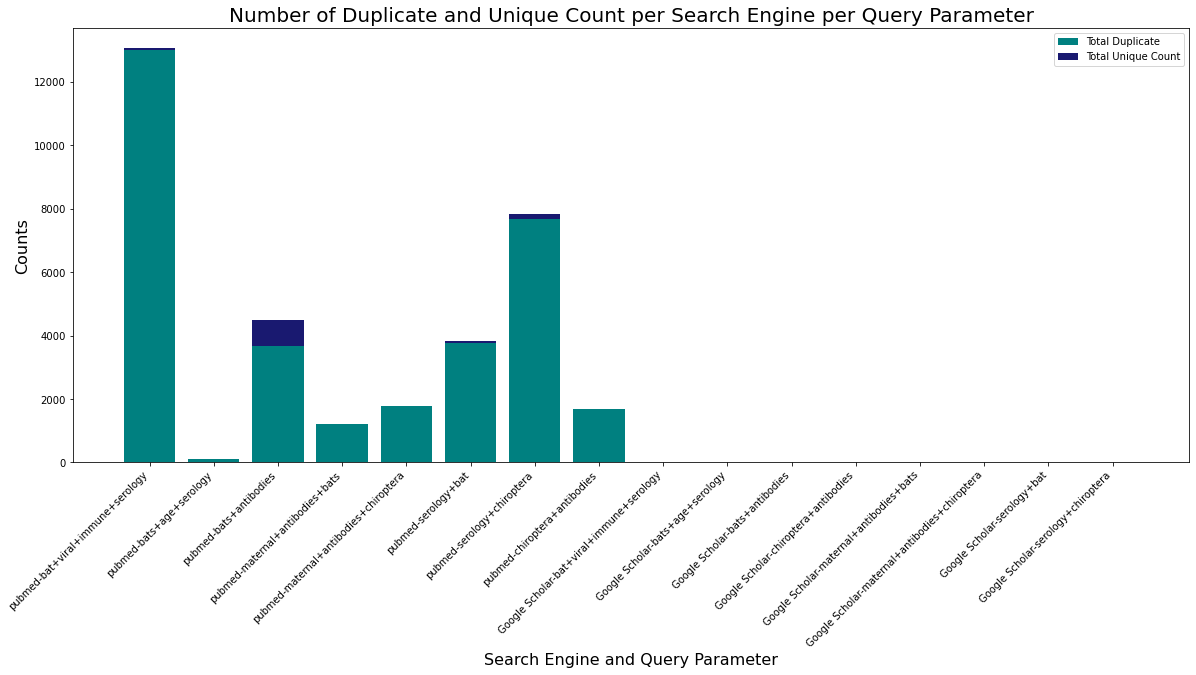

In [245]:
plt.figure(figsize = (20,8))
plt.bar(mergedCounts['SE + Query'], mergedCounts['Total Duplicate'], color='teal')
plt.bar(mergedCounts['SE + Query'], mergedCounts['Total Unique Count'], bottom=mergedCounts['Total Duplicate'], color='midnightblue')
plt.xlabel("Search Engine and Query Parameter", fontsize=16)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Counts", fontsize=16)
plt.legend(["Total Duplicate", "Total Unique Count"])
plt.title("Number of Duplicate and Unique Count per Search Engine per Query Parameter", fontsize=20)
plt.show()

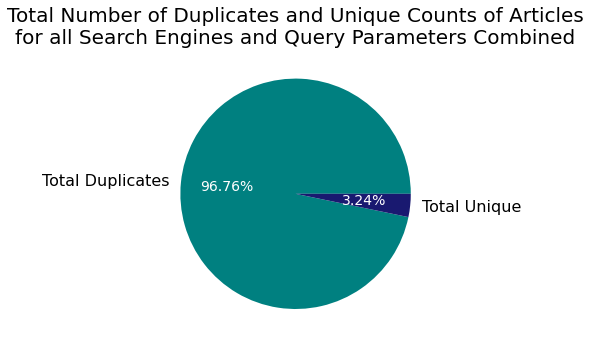

In [256]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
labels = ['Total Duplicates', 'Total Unique']
totalDup = mergedCounts['Total Duplicate'].sum()
totalUnique = mergedCounts['Total Unique Count'].sum()
counts = [totalDup, totalUnique]
patches, texts, autotexts = ax.pie(counts, colors=['teal', 'midnightblue'], labels=labels,autopct='%1.2f%%')
texts[0].set_fontsize(16)
texts[1].set_fontsize(16)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(14)
plt.title("Total Number of Duplicates and Unique Counts of Articles\nfor all Search Engines and Query Parameters Combined", fontsize=20)
fig.set_facecolor('white')
plt.show()

<h3>Natural Language Processing:</h3>

<h4>Identifying all rows that reference bats in the title and those that do not:</h4>

In [110]:
#need to make sure there are no 'na' values. Part of literature compilation requires being able to track what is not used, thus, pulling any NA values out as their own dataframe so they are documented if needed:
dfNATitle = dfUnique2[dfUnique2['Title'].isna()]

In [111]:
print(f"Identifying all rows that have missing Titles. There were {len(dfNATitle)} articles identified.")

Identifying all rows that have missing Titles. There were 0 articles identified.


In [100]:
#uploading stopwords as as set from NLTK
stop_words = set(stopwords.words('english'))

In [179]:
#making all text in 'Title' column lowercase as its own column called 'Title NLP'
dfUnique2['Title NLP'] = dfUnique2['Title'].apply(str.lower)

#removing stop words from the 'Title' column of the dataframe structured for NLP on the titles
dfUnique2['Title NLP'] = dfUnique2['Title NLP'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

#removing punctuation
dfUnique2['Title NLP'] = dfUnique2['Title NLP'].str.replace('[{}]'.format(string.punctuation), '')

<ipython-input-179-f804a003eccf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfUnique2['Title NLP'] = dfUnique2['Title'].apply(str.lower)
<ipython-input-179-f804a003eccf>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfUnique2['Title NLP'] = dfUnique2['Title NLP'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
<ipython-input-179-f804a003eccf>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  dfUnique2['Title NLP'] 

In [180]:
#Confirming filtering worked
dfUnique2["Title NLP"][0:5]

0    detection serum antibody responses nipah virus...
1    priming conditions shape breadth neutralizing ...
2    sarscov2 omicron variant emerged immune selection
3    glycoproteins predicted amphibian reptile lyss...
4              bat virome research past present future
Name: Title NLP, dtype: object

In [131]:
#opening a user defined text file that contains all words that reference bats as a list. Includes bat families, genera, common names, etc.
with open("keywords/keywords_bats.txt", 'r') as f:
    for line in f:
        bats = line.split(",")

bats = [x.lower() for x in bats]
search_ = re.compile("\\b%s\\b" % "\\b|\\b".join(bats))

In [181]:
#Add a column called "Matches" that returns a list of each word in the abstract that also appears in the search_ list
dfUnique2['Matches'] = dfUnique2['Title NLP'].str.findall(search_)

<ipython-input-181-9d085e52f107>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfUnique2['Matches'] = dfUnique2['Title NLP'].str.findall(search_)


In [182]:
#altering Matches column to strip away concurrent ',' values and values a list
vList = []
for v in dfUnique2['Matches']:
    #walrus operator to get rid of blank values and extra commas
    v = ",".join(e for ee in v if (e := ee.strip())).split(",")
    vList.append(list(v))

dfUnique2["Matches"] = vList

<ipython-input-182-1bb5faac6f4e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfUnique2["Matches"] = vList


In [183]:
#if values are a list that meet this description: [''], turn them into an empty list
for i, v in dfUnique2.iterrows():
    if v["Matches"] == ['']:
         dfUnique2.loc[i,'Matches'] = []

<ipython-input-183-9b3789e69c12>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfUnique2.loc[i,'Matches'] = []


In [184]:
#appending a new column that counts the number of times a "bat" reference was made in the title (i.e. counts length of lists in "Matches" column)
dfUnique2["Count of 'bat' in Title"] = [len(l) for l in dfUnique2['Matches']]


<ipython-input-184-dae19660cd13>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfUnique2["Count of 'bat' in Title"] = [len(l) for l in dfUnique2['Matches']]


In [185]:
dfUnique2.head()

,Title,Authors,Publication Year,Abstract,Journal/Source,Citation,Publication Date,DOI,Time Stamp,Query Parameters,Search Engine,Links,Title NLP,Matches,Count of 'bat' in Title
0,Detection of Serum Antibody Responses in Nipah...,"Fischer K, Pickering B, Diederich S.",2023;2610:17-29,"Nipah virus (NiV) is an emerging, zoonotic par...",Methods Mol Biol,2610:17-29,2023,10.1007/978-1-0716-2895-9_2.,2023,bat+viral+immune+serology,pubmed,NaN,detection serum antibody responses nipah virus...,[],0
1,Priming conditions shape breadth of neutralizi...,"Jia JZ(#), Tan CW(#), Cheng SMS, Gu H, Yeoh AY...",2022,Vaccines that are broadly cross-protective aga...,Nat Commun,13(1):6285,2022 Oct 21,10.1038/s41467-022-34038-6.,2022 Oct 21,bat+viral+immune+serology,pubmed,NaN,priming conditions shape breadth neutralizing ...,[],0
2,SARS-CoV-2 Omicron variant emerged under immun...,"Tan CW, Chia WN, Zhu F, Young BE, Chantasrisaw...",2022,The SARS-CoV-2 Omicron variant (B.1.1.529 line...,Nat Microbiol,7(11):1756-1761,2022 Nov,10.1038/s41564-022-01246-1,2022 Nov,bat+viral+immune+serology,pubmed,NaN,sarscov2 omicron variant emerged immune selection,[],0
3,Glycoproteins of Predicted Amphibian and Repti...,"Oberhuber M, Schopf A, Hennrich AA, Santos-Man...",2021,Lyssaviruses are neurotropic rhabdoviruses tho...,Viruses,13(9):1726,2021 Aug 30,10.3390/v13091726.,2021 Aug 30,bat+viral+immune+serology,pubmed,NaN,glycoproteins predicted amphibian reptile lyss...,[],0
4,"Bat virome research: the past, the present and...","Tan CW, Yang X, Anderson DE, Wang LF.",2021,Bats have been increasingly recognised as an e...,Curr Opin Virol,49:68-80,2021 Aug,10.1016/j.coviro.2021.04.013,2021 Aug,bat+viral+immune+serology,pubmed,NaN,bat virome research past present future,[bat],1


In [187]:
#creating a new dataframe that contains all rows that had 0 bat references in the title
noBatDF = dfUnique2[dfUnique2["Count of 'bat' in Title"] == 0]

In [188]:
#dropping the above dataframe from the original dataframe
dfUnique3 = dfUnique2.drop(noBatDF.index)

In [189]:
print(f'{len(noBatDF)} rows were dropped from the dataframe. The dataframe did contain {len(dfUnique2)} rows. Now it contains {len(dfUnique3)} rows.')

560 rows were dropped from the dataframe. The dataframe did contain 1108 rows. Now it contains 548 rows.


<h4>Assigning a relevancy score based on words in abstract of each article:</h4>

Data Preparation:

In [190]:
#creating a dataframe that is a subset of the working dataframe containing all rows where 'Abstract' column is nan
dfNA = dfUnique3[dfUnique3['Abstract'].isna()]

In [210]:
print(f"{len(dfNA)} rows contain NA values in the Abstract column.")

53 rows contain NA values in the Abstract column.


In [193]:
#dropping rows that have NaN values
dfUnique4 = dfUnique3.drop(dfNA.index)

In [194]:
print(f'{len(dfNA)} rows were dropped from the dataframe. The dataframe did contain {len(dfUnique3)} rows. Now it contains {len(dfUnique4)} rows.')

53 rows were dropped from the dataframe. The dataframe did contain 548 rows. Now it contains 495 rows.


Making a word cloud:

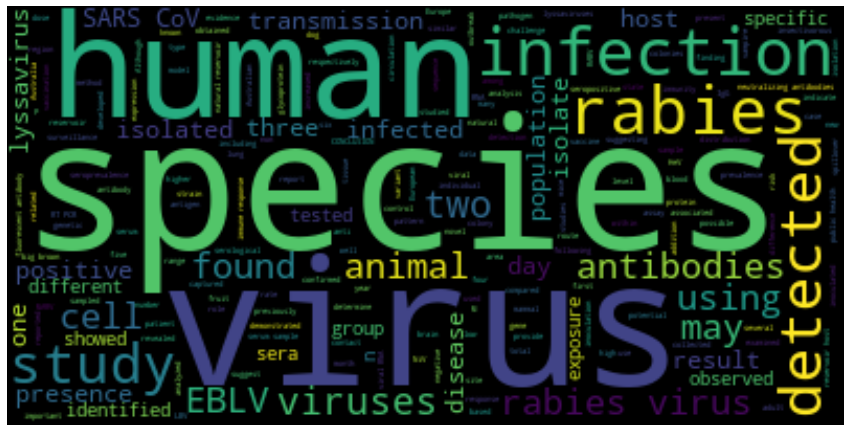

In [211]:
lemmatizer = WordNetLemmatizer()

text = " ".join(dfUnique4.Abstract)

#Fix contractions
new_word = contractions.fix(text)
#Lemmatize
lem_word = lemmatizer.lemmatize(new_word)

#Wordcloud with removed stopwords
stopwords = ['bats', 'bat'] + list(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="black").generate(lem_word)
plt.figure(figsize = (15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [196]:
#making all text in 'Abstract' column lowercase as its own column called 'Abstract NLP'
dfUnique4['Abstract NLP'] = dfUnique4['Abstract'].apply(str.lower)

#removing stop words from the 'Abstract' column of the dataframe structured for NLP on the abstracts
dfUnique4['Abstract NLP'] = dfUnique4['Abstract NLP'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

#removing punctuation
dfUnique4['Abstract NLP'] = dfUnique4['Abstract NLP'].str.replace('[{}]'.format(string.punctuation), '')

<ipython-input-196-7c445967f641>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  dfUnique4['Abstract NLP'] = dfUnique4['Abstract NLP'].str.replace('[{}]'.format(string.punctuation), '')


In [197]:
#checking out put of 'Abstract NLP' column:
dfUnique4['Abstract NLP'][0:4]

4     bats increasingly recognised exceptional reser...
5     australian bat lyssavirus ablv rhabdovirus cir...
8     batborne zoonotic pathogens belonging family p...
10    human rabies vaccines shown induce partial pro...
Name: Abstract NLP, dtype: object

In [198]:
#opening a user defined text file that contains all words that reference subject matter of interest to further filter publications on

with open("keywords/keywords_general.txt", 'r') as f:
    for line in f:
        keywords = line.split(",")

keywords = [x.lower() for x in keywords]
search_2 = re.compile("\\b%s\\b" % "\\b|\\b".join(keywords))

In [199]:
#Add a column called "Keyword Matches" that returns a list of each word in the abstract that also appears in the search_2 list
dfUnique4['Keyword Matches'] = dfUnique4['Abstract NLP'].str.findall(search_2)

In [201]:
#Turning each list in "Keyword Matches" to a set of unique values
dfUnique4['Keyword Matches'] = dfUnique4['Keyword Matches'].apply(set)

In [202]:
dfUnique4['Keyword Matches'][0:5]

4               {serology}
5      {virus, antibodies}
8             {antibodies}
10            {antibodies}
11    {immunity, serology}
Name: Keyword Matches, dtype: object

In [203]:
#user defined dictionary where the key is each keyword supplied by the user and the value is the weight of that keyword assinged by the user:
relevancyKey = {'maternal antibodies': 5, 'maternal antibody': 5, 'seasonal pattern': 5, 'seasonal patterns': 5, 'seasonal': 5, 'seasonality': 5, 'juvenile': 4, 'pups': 4, 'pup': 4, 'serology': 3, 'antibody': 3, 'antibodies': 3, 'antibody response': 3, 'seroprevalence': 3, 'maternity roost': 3, 'immunity': 2, 'immune response': 2, 'virus': 1, 'viruses': 1, 'viral': 1, 'prevalence': 1}

#plan for further improvement: use regex to capture all the word presentations (example: serology, serologies, serostudy, seroprevalence)

#other words to consider incorporation: viral-host response, viral ecology, etc.

In [204]:
#For every keyword in the set in the Keyword Matches column, summing up the value of those words as described above and populating a new column 'Relevancy Score'
relevancy = []
for s in dfUnique4['Keyword Matches']:
    count = 0
    for e in s:
        for k, v in relevancyKey.items():
            if e == k:
                count += v
    relevancy.append(count)

dfUnique4['Relevancy Score'] = relevancy

In [205]:
#Sorting dataframe by 'Relevancy Score'
dfUnique4 = dfUnique4.sort_values(by='Relevancy Score', ascending=False)

In [207]:
#Comparing 'Relevancy Score' to 'Title' to assess results 
for k, v in dfUnique4.iterrows():
    print("Title:", v["Title"])
    print("Rank:", v["Relevancy Score"])
    print('*'*50)

Title: Duration of Maternal Antibodies against Canine Distemper Virus and Hendra Virus in Pteropid Bats.
Rank: 18
**************************************************
Title: Disentangling serology to elucidate henipa- and filovirus transmission in Madagascar fruit bats.
Rank: 13
**************************************************
Title: Antibody Responses to Marburg Virus in Egyptian Rousette Bats and Their Role in Protection against Infection.
Rank: 13
**************************************************
Title: Active surveillance for antibodies confirms circulation of lyssaviruses in Palearctic bats.
Rank: 12
**************************************************
Title: Viral Ecology and Natural Infection Dynamics of Kaeng Khoi Virus in Cave-Dwelling Wrinkle-Lipped Free-Tailed Bats (Chaerephon plicatus) in Thailand.
Rank: 11
**************************************************
Title: Longitudinal survey of two serotine bat (Eptesicus serotinus) maternity colonies exposed to EBLV-1 (European Bat

<h4>Re-assessing those records that were filtered out--i.e. no 'bat' referenced in title and abstract value of nan: </h4>

For those papers with which bat was not referenced in the title, checking to see if bat was referenced in the abstract:

Citations:

Research Gate Project:
https://selenium-python.readthedocs.io --current selenium syntax and functionality.
https://www.geeksforgeeks.org --best for dataframe manipulation syntax and nlp syntax.
https://www.researchgate.net --site for information exraction
https://www.nltk.org --NLP documentation and functionality
https://pypi.org/project/gensim/ --NLP documentation and functionality